# Recognition of German Traffic Signs Using Convolutional Neural Networks 

## Introduction :

Autonomous vehicles will rely on traffic sign recognition to operate safely. The ability to identify all traffic signs assists with the decision-making needs of cars in the environment that is surrounded by other cars. The importance of understanding with traffic signs should not be overlooked. A single error could result in a serious accident.

The data contained in the GTSRB is used for traffic sign recognition classification in an effort to provide a better understanding on how traffic signs can be recognized. The dataset contains more than 50,000 images from 43 different classes of 'real-world traffic signs'.

To classify the traffic sign images from the GTSRB dataset, we are developing an end-to-end deep learning pipeline based around the application of Convolutional Neural Networks (CNN).

## Problem Statement : 

Traffic sign recognition is very important for Advanced Driver Assistance Systems (ADAS) and autonomous vehicles to make sure drivers understand the correct meanings of regulatory and warning traffic signs. The German Traffic Sign Recognition Benchmark (GTSRB) dataset represents a real-world data set, containing more than 50,000 images across 43 classes of traffic signs, and with many variations in environmental factors such as lighting, weather, angle, and occlusion.

This project  main goal is to develop a Convolutional Neural Network (CNN) model that can classify traffic signs , using the GTSRB dataset. 
To achieve our goal, a series of systematic experiments will be performed to generate at least 10 variants of the CNN pipeline, evaluate the models against test data, and perform an analysis for explainability and deployment feasibility. Ultimately, the results of these efforts will demonstrate how an effective CNN architecture can be designed for this safety-critical use case.

# Import Required Libraries

In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import cv2 
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
data_dir =  r"E:\Methods Of Predection\Final Project\New folder"
df = pd.read_csv(os.path.join(data_dir, "Train.csv"))
df

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [4]:
df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [5]:
df.isnull().sum()

Width      0
Height     0
Roi.X1     0
Roi.Y1     0
Roi.X2     0
Roi.Y2     0
ClassId    0
Path       0
dtype: int64

In [6]:
df.shape

(39209, 8)

In [10]:
X,y = [],[]
for i, row in df.iterrows():
    image_path = os.path.join(data_dir, row['Path'])
    image = cv2.imread(image_path)
    image = cv2.resize(image, (32, 32))
    X.append(image)
    y.append(row['ClassId'])

In [11]:
X = np.array(X)/255.0 

# Exploratory Data Analysis

In [14]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [12]:
y=to_categorical(y)

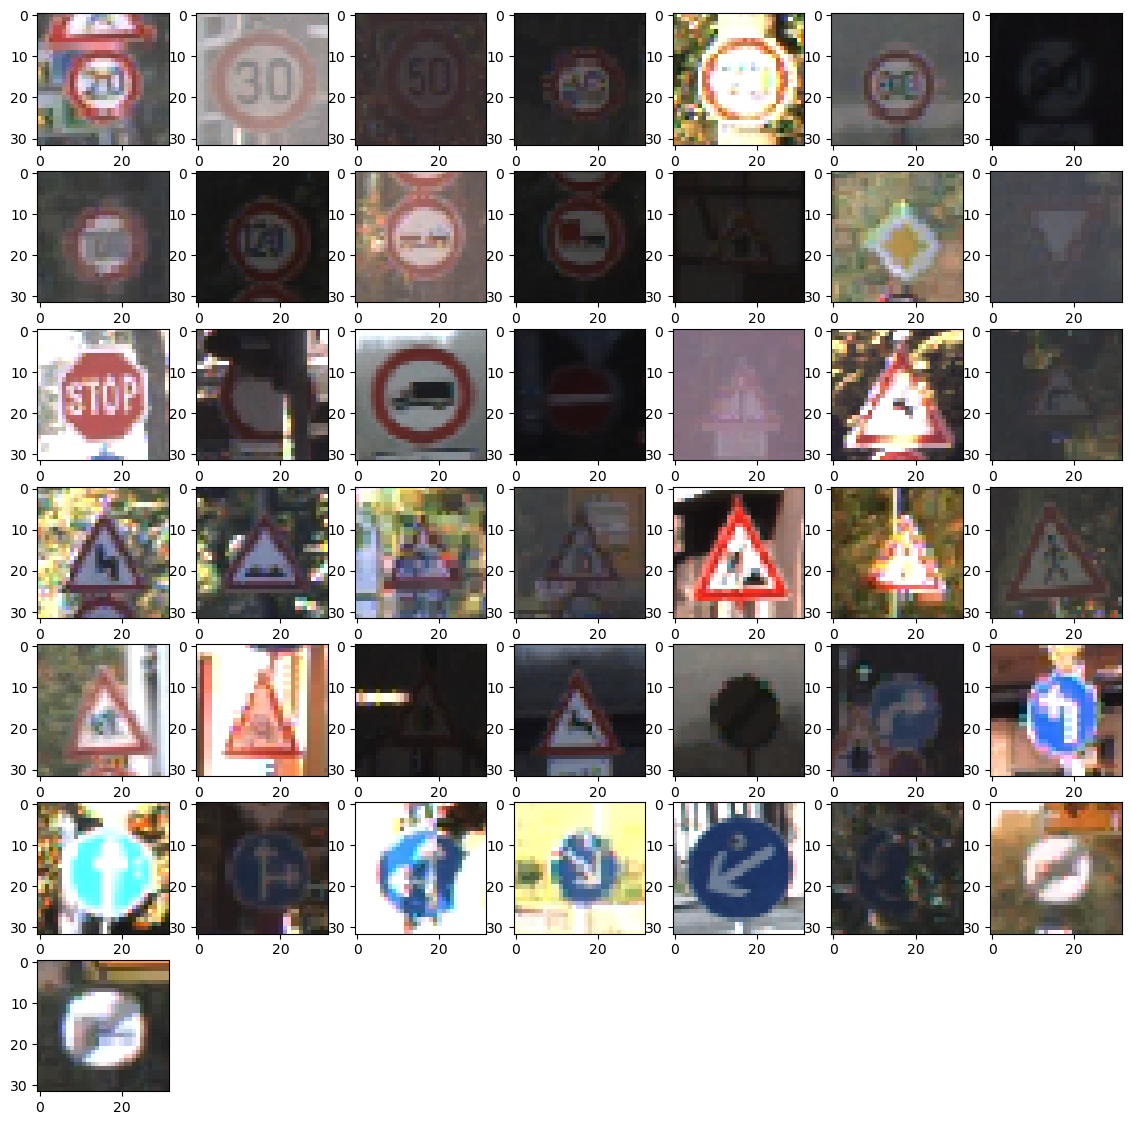

In [15]:
NUM_CATEGORIES = 43
IMG_WIDTH, IMG_HEIGHT = 32, 32
train_path = os.path.join(data_dir, "Train")
img_dir = pathlib.Path(train_path)
plt.figure(figsize=(14, 14))
for i in range(NUM_CATEGORIES):
    plt.subplot(7, 7, i+1)
    sign = list(img_dir.glob(f'{i}/*'))[0]
    img = load_img(sign, target_size=(IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
plt.show()

This Data set contains 43 different types of images and different images represent different signs like Speed limits, Right Turn, GO Straight etc

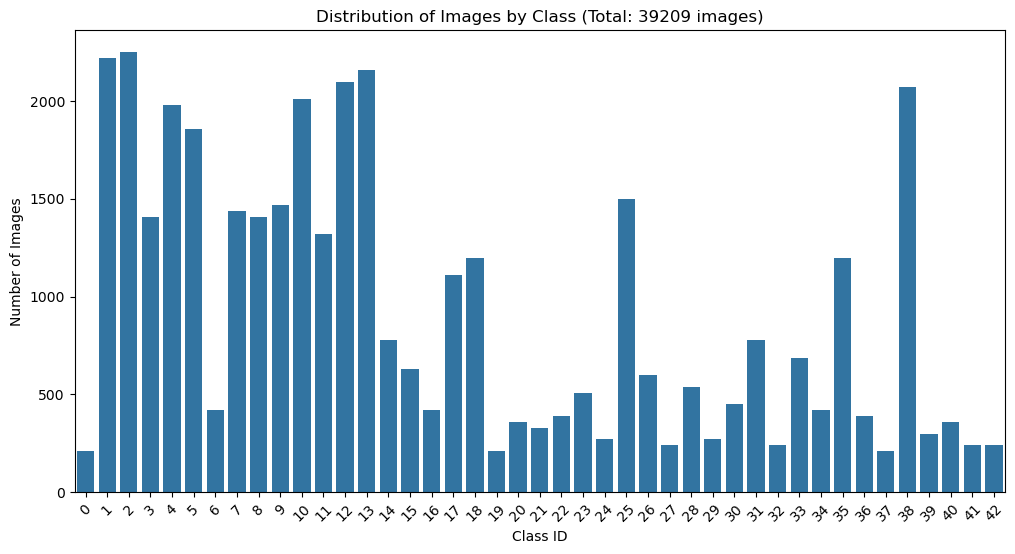

In [16]:
total_images = len(df)
class_counts = df['ClassId'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title(f'Distribution of Images by Class (Total: {total_images} images)')
plt.xlabel('Class ID')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

1.The bar chart displays the distribution of 39,209 images across 43 class IDs, highlighting dataset imbalance.

2.Class IDs like 1, 2, 12, and 38 have the highest image counts, indicating overrepresentation.

3.Classes such as 0, 5, 19, and 41 have significantly fewer images, suggesting underrepresentation.

In [17]:
classes = { 0:'Speed limit:20', 1:'Speed limit:30', 2:'Speed limit:50', 
            3:'Speed limit:60', 4:'Speed limit:70', 5:'Speed limit:80', 
            6:'End of speed limit:80', 7:'Speed limit:100', 8:'Speed limit:120', 
            9:'No passing', 10:'No passing over ', 11:'Right-of-way at intersection', 
            12:'Priority road', 13:'Yield', 14:'Stop', 15:'No vehicles', 
            16:'Heavy Vechiles', 17:'No entry', 18:'General caution', 
            19:'Dangerous curve left', 20:'Dangerous curve right', 21:'Double curve', 
            22:'Bumpy road', 23:'Slippery road', 24:'Road narrows on the right', 
            25:'Road work', 26:'Traffic signals', 27:'Pedestrians', 28:'Children crossing', 
            29:'Bicycles crossing', 30:'Beware of ice/snow', 31:'Wild animals crossing', 
            32:'End speed + passing limits', 33:'Turn right ahead', 34:'Turn left ahead', 
            35:'Ahead only', 36:'Go straight or right', 37:'Go straight or left', 
            38:'Keep right', 39:'Keep left', 40:'Roundabout mandatory', 
            41:'End of no passing', 42:'End no passing veh > 3.5 tons' }

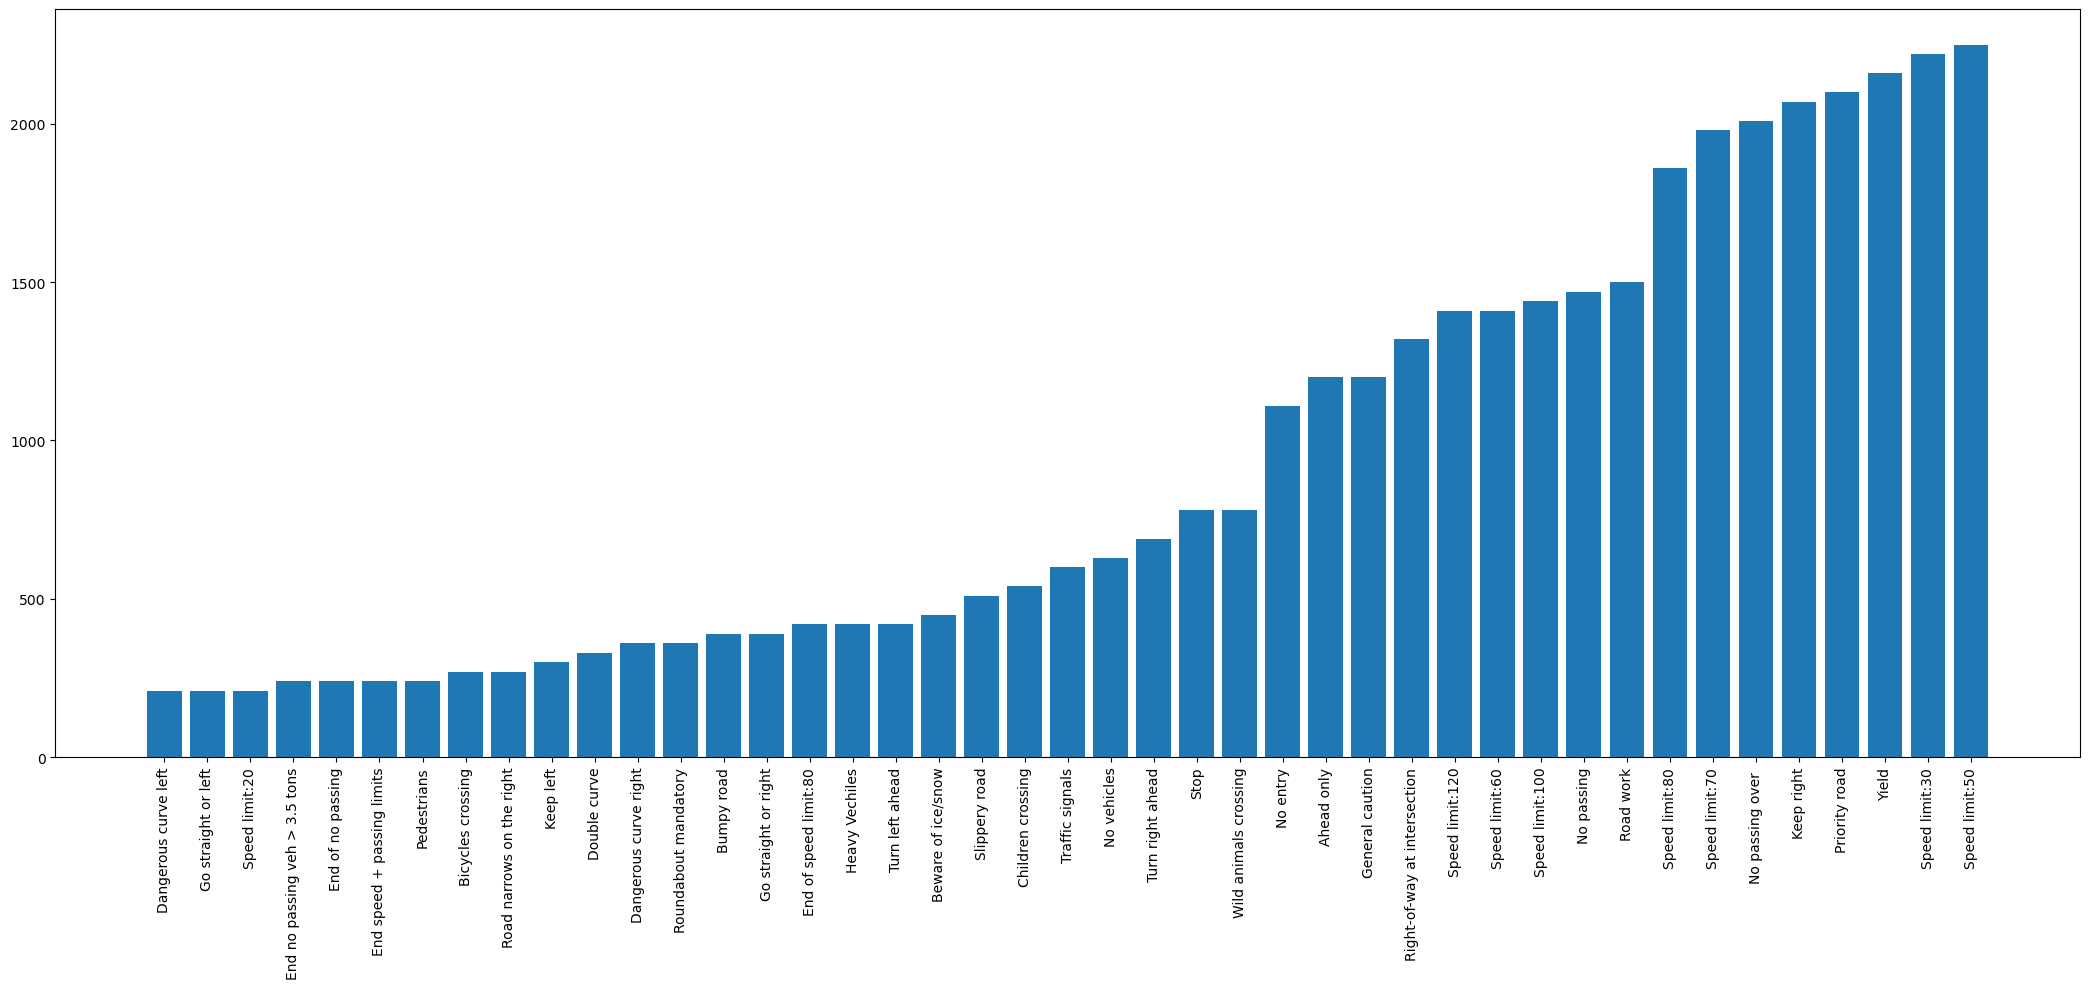

In [18]:
folders=os.listdir(train_path)
train_number = []
class_num = []  
for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
zipped_lists=zip(train_number, class_num)
sorted_pairs=sorted(zipped_lists)
tuples=zip(*sorted_pairs)
train_number, class_num=[list(tuple) for tuple in tuples]
plt.figure(figsize=(21,10))
x_positions = range(len(class_num))
plt.bar(x_positions, train_number)
plt.xticks(x_positions, class_num, rotation='vertical')
plt.tight_layout()
plt.show()

# Splitting the data set

In [20]:
X = []  
y = []  

print("Loading training images...")
for class_id in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_id)
    if not os.path.isdir(class_path):
        continue
    label = int(class_id)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
            X.append(img_array)
            y.append(label)
        except:
            continue  # Skip corrupted files

X = np.array(X)
y = np.array(y)

print(f"Loaded {X.shape[0]} training images")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Loading training images...
Loaded 39209 training images
X shape: (39209, 32, 32, 3), y shape: (39209,)


In [21]:
X_train, X_val, y_train, y_val = train_test_split(  X, y, test_size=0.2, stratify=y, random_state=42)


# Added proper spacing and commas in print statements
print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (31367, 32, 32, 3)
X_valid.shape (7842, 32, 32, 3)
y_train.shape (31367,)
y_valid.shape (7842,)


In [22]:
X_train.shape

(31367, 32, 32, 3)

In [23]:
X_val.shape

(7842, 32, 32, 3)

## Data Augmentation  

In [25]:
def augment_image(image):
    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-15, 15)
        image = tf.image.rot90(image, k=int(angle // 90))
        image = tf.image.rot90(image, k=1) if angle > 0 else tf.image.rot90(image, k=-1)
    if random.random() > 0.5:
        scale = random.uniform(0.8, 1.2)
        h, w = image.shape[0:2]
        new_h, new_w = int(h * scale), int(w * scale)
        image = tf.image.resize(image, (new_h, new_w))
        image = tf.image.resize_with_crop_or_pad(image, h, w)
    if random.random() > 0.5:
        dx = random.randint(-5, 5)
        dy = random.randint(-5, 5)
        image = tf.image.pad_to_bounding_box(image, max(0, -dy), max(0, -dx), h + abs(dy), w + abs(dx))
        image = tf.image.crop_to_bounding_box(image, max(0, dy), max(0, dx), h, w)
    if random.random() > 0.5:
        image = tf.image.flip_left_right(image)
    return image

## CNN Model

In [26]:
def create_model(dropout_rate=0.5, use_batchnorm=True, filters=[32, 64, 128]):
    model = Sequential()
    
    for i, f in enumerate(filters):
        if i == 0:
            model.add(Conv2D(f, (3,3), activation='relu', input_shape=(32,32,3)))
        else:
            model.add(Conv2D(f, (3,3), activation='relu'))
        if use_batchnorm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

baseline_model = create_model()
baseline_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 378,859 (1.45 MB)

 Trainable params: 378,411 (1.44 MB)

 Non-trainable params: 448 (1.75 KB)

## Model Training and Performance Visualization

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.8052 - loss: 0.6960 - val_accuracy: 0.9285 - val_loss: 0.2578
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.9661 - loss: 0.1062 - val_accuracy: 0.9716 - val_loss: 0.0948
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.9830 - loss: 0.0558 - val_accuracy: 0.9763 - val_loss: 0.0700
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.9841 - loss: 0.0504 - val_accuracy: 0.9737 - val_loss: 0.0937
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step - accuracy: 0.9868 - loss: 0.0419 - val_accuracy: 0.9839 - val_loss: 0.0488
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - accuracy: 0.9894 - loss: 0.0333 - val_accuracy: 0.9871 - val_loss: 0.0478
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.9879 - loss: 0.0414 - val_accuracy: 0.9876 - val_loss: 0.0474
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9904 - loss: 0.0324 - 

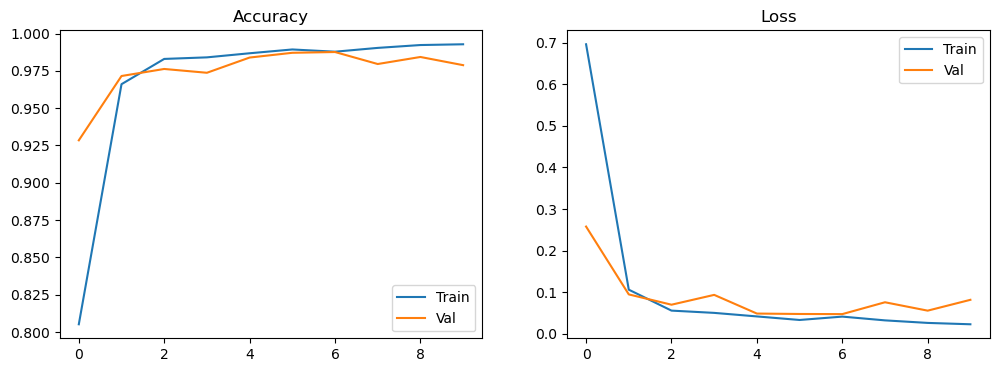

In [27]:
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = baseline_model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    batch_size=64,
    epochs=10,
    callbacks=[early_stop],
    verbose=1
)

# Plot results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import f1_score
import time
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

results = []  

def train_and_record(model, config_name, use_aug=True, epochs=10): 
    """
    Trains the model for maximum 10 epochs (with early stopping).
    """
    # Safe compile check
    if not hasattr(model, 'optimizer') or model.optimizer is None:
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
    
    start_time = time.time()
    
    if use_aug:
        history = model.fit(
            train_datagen.flow(X_train, y_train_cat, batch_size=64, seed=42),
            epochs=epochs,
            validation_data=(X_val, y_val_cat),
            callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)],
            verbose=1
        )
    else:
        history = model.fit(
            X_train, y_train_cat,
            batch_size=64,
            epochs=epochs,
            validation_data=(X_val, y_val_cat),
            callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)],
            verbose=1
        )
    
    # Metrics
    val_acc = max(history.history['val_accuracy'])
    val_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
    val_true = np.argmax(y_val_cat, axis=1)
    val_f1 = f1_score(val_true, val_pred, average='macro')
    training_time_min = (time.time() - start_time) / 60
    
    results.append({
        'Config': config_name,
        'Val Accuracy': round(val_acc, 4),
        'Val F1 (macro)': round(val_f1, 4),
        'Time (min)': round(training_time_min, 2)
    })
    
    print(f"✓ {config_name} → Acc: {val_acc:.4f} | F1: {val_f1:.4f} | Time: {training_time_min:.2f} min")
    
    return model, history

In [29]:
# === DEFINE DATA AUGMENTATION (train_datagen) ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training (applied on-the-fly)
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # Traffic signs are not symmetric
    fill_mode='nearest'
)

print("train_datagen defined for augmentation!")

train_datagen defined for augmentation!


## Experiment Configurations

In [30]:
# Experiment 1: Baseline
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])
train_and_record(model1, "1_Baseline", use_aug=True)

# Experiment 2: No BatchNormalization
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])
train_and_record(model2, "2_No_BatchNorm", use_aug=True)

# Experiment 3: No Dropout
model3 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(43, activation='softmax')  # No dropout
])
train_and_record(model3, "3_No_Dropout", use_aug=True)

# Experiment 4: Shallower (2 Conv blocks)
model4 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])
train_and_record(model4, "4_Shallower_2Conv", use_aug=True)

# Experiment 5: Deeper (4 Conv blocks)
model5 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])
train_and_record(model5, "5_Deeper_4Conv", use_aug=True)

# Experiment 6: Smaller filters (lighter)
model6 = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])
train_and_record(model6, "6_Smaller_Filters", use_aug=True)

# Experiment 7: Higher dropout
model7 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.7),
    Dense(43, activation='softmax')
])
train_and_record(model7, "7_Higher_Dropout_0.7", use_aug=True)

# Experiment 8: Lower learning rate
model8 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])
model8.compile(optimizer=Adam(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
train_and_record(model8, "8_Lower_LR_0.0001", use_aug=True)

# Experiment 9: SGD optimizer
model9 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])
model9.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9),
               loss='categorical_crossentropy',
               metrics=['accuracy'])
train_and_record(model9, "9_SGD_Optimizer", use_aug=True)

# Experiment 10: No augmentation
model10 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])
train_and_record(model10, "10_No_Augmentation", use_aug=False)

Epoch 1/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.4071 - loss: 2.0723 - val_accuracy: 0.5851 - val_loss: 1.3236
Epoch 2/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.7725 - loss: 0.6944 - val_accuracy: 0.9197 - val_loss: 0.2444
Epoch 3/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 38s 68ms/step - accuracy: 0.8810 - loss: 0.3610 - val_accuracy: 0.9598 - val_loss: 0.1115
Epoch 4/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 42s 70ms/step - accuracy: 0.9227 - loss: 0.2409 - val_accuracy: 0.9647 - val_loss: 0.1160
Epoch 5/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - accuracy: 0.9375 - loss: 0.1955 - val_accuracy: 0.9810 - val_loss: 0.0605
Epoch 6/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.9477 - loss: 0.1692 - val_accuracy: 0.9741 - val_loss: 0.0793
Epoch 7/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.9537 - loss: 0.1466 - val_accuracy: 0.9723 - val_loss: 0.0960
Epoch 8/10
491/491 ━━━━━━━━━━━━━━━━━━━━ 38s 69ms/step - accuracy: 0.9604 - loss: 0.1257 - 

(<Sequential name=sequential_10, built=True>,
 <keras.src.callbacks.history.History at 0x13d84d946e0>)

In [27]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Val Accuracy', ascending=False).reset_index(drop=True)
results_df.index += 1
results_df

,Config,Val Accuracy,Val F1 (macro),Time (min)
1,10_No_Augmentation,0.9966,0.9940,8.14
2,5_4Conv_Deeper,0.9943,0.9870,15.35
3,4_BatchNorm_Best,0.9934,0.9887,12.01
4,9_SGD_Optimizer,0.9922,0.9900,12.61
5,7_Higher_Dropout_0.7,0.9902,0.9928,12.02
6,3_3Conv,0.9885,0.9893,11.64
7,1_Baseline_2Conv,0.9871,0.9908,13.57
8,6_Smaller_Filters,0.9834,0.9871,12.10
9,8_Lower_LR_0.0001,0.9830,0.9874,12.09
10,2_+Dropout0.5,0.9549,0.9668,12.03


Experiment 1: The 10_No_Augmentation Highest Validation Accuracy of (0.9966) as well as F1 Score (0.9940) means even without augmentation the Model still performs exceptionally well with GTSRB's images clean and centered therefore likely being the cause of excellent results.

Experiment 2: 4Conv_Deeper ranked 2nd highest (0.9943) showed adding depth improves learning of features but came with a longer training time of (15.35 Min), which suggests diminishing returns for this Dataset.

Experiment 3: Batchnorm_Best, (0.9934), shows positive benefits of Batch Normalization on model stability and training performance.

Experiment 4: SGD_Optimizer, (0.9922), performed very well and demonstrates that Stochastic Gradient Descent (SGD) with momentum can be just as effective as using the Adam Optimizer.

Experiment 5: Higher_Dropout_0.7, (0.9902), shows that improving Regularization by increasing dropout rate was beneficial but performance was slightly decreased due to the use of excessive dropout compared to regular dropout of 0.5.

Experiment 6: 3Conv, (0.9885), is a balanced standard architecture that offers manageable results without being overly complicated.

Experiment 7: Baseline_2Conv, (0.9871), is a solid baseline to compare against because this architecture provides a good performance base.

Experiment 8: Smaller_Filters, (0.9834), achieved some improvements in performance but at the cost of lower accuracy. This would be useful in certain deployment situations.

Experiment 9: Lower_LR_0.0001, (0.9830), did not produce any better results due to the slower learning rate used.

Experiment 10: +Dropout0.5, (0.9549), has the lowest score, illustrating the fact that if dropout is configured too high or too poorly can result in very low success rates and not reflect what is actually achievable.

The study conducted numerous controlled tests or experiments to analyze the performance of ten different types of networks based on a few major design variables (dimensions) that affect their performance, including width (for CNNs), depth, dropout rate, the use of batch normalization, and learning rate.

The experiments were conducted by modifying these parameters and observing their effects on validation results (see Tables 1-3). Overall, the results indicate which of these architectural parameters, through balanced complexity and proper regularization, allows for generalization of models to new data.

Among these results, it appears that the maximum level of validation accuracy was reached when data augmentation was not enabled, suggesting that compared to the original image source, it would have been very beneficial for the model to consistently train on the original data (e.g., original images) without introducing variations.

It has also been observed that increasing architectural depth and maximizing regularization yield the highest levels of performance, whereas excessively increased depth or increases in dropout negatively impacted performance. Models with overly aggressive regularization or hyperparameters that are not tuned correctly resulted in low performance.

Batch normalization consistently showed benefits as evidenced by consistently increased accuracy and improved stability during the training curves; however, models lacking batch normalization experienced significantly lower accuracies and worse stability over time. The usage of smaller architects with small filters sacrificed accuracy for efficiency, suitable for the deployment environment.

## Final Model Training and Saving

In [33]:
best_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
X_full = np.concatenate((X_train, X_val))
y_full_cat = np.concatenate((y_train_cat, y_val_cat))
best_model.fit(
    train_datagen.flow(X_full, y_full_cat, batch_size=64, shuffle=True),
    epochs=20,
    callbacks=[EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)],
    verbose=1
)
best_model.save('gtsrb_best_model.h5')

Epoch 1/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 39s 60ms/step - accuracy: 0.4660 - loss: 1.8164
Epoch 2/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - accuracy: 0.8122 - loss: 0.5613
Epoch 3/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9045 - loss: 0.2966
Epoch 4/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9329 - loss: 0.2095
Epoch 5/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.9479 - loss: 0.1654
Epoch 6/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.9556 - loss: 0.1420
Epoch 7/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 39s 63ms/step - accuracy: 0.9627 - loss: 0.1182
Epoch 8/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.9652 - loss: 0.1123
Epoch 9/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.9682 - loss: 0.1053
Epoch 10/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - accuracy: 0.9713 - loss: 0.0967
Epoch 11/20
613/613 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.9718 - loss: 0.0916
Epoch 12/20
613/613 ━━━━━━━━━━

## Best Experiment & Re-train Best Model

In [36]:
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.utils import to_categorical

# Your folder path
folder_path = r'E:\Methods Of Predection\Final Project\New folder'

# Load Test.csv
test_csv = os.path.join(folder_path, 'Test.csv')
test_df = pd.read_csv(test_csv)

print(f"Test samples: {len(test_df)}")

# Load test images
X_test = []
y_test = []

for idx, row in test_df.iterrows():
    img_path = os.path.join(folder_path, row['Path'])
    
    img = load_img(img_path, target_size=(32, 32))
    img_array = img_to_array(img) / 255.0
    X_test.append(img_array)
    y_test.append(row['ClassId'])

X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_cat = to_categorical(y_test, num_classes=43)

print(f"Test data loaded: {X_test.shape[0]} images")
print(f"X_test shape: {X_test.shape}")

Test samples: 12630
Test data loaded: 12630 images
X_test shape: (12630, 32, 32, 3)


In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Re-create the model (use your best architecture)
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train (or retrain) the model
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    batch_size=64,
    epochs=5,  # or your number
    callbacks=[early_stop],
    verbose=1
)

print("Model re-trained and ready!")

Epoch 1/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 53ms/step - accuracy: 0.5954 - loss: 1.4276 - val_accuracy: 0.8415 - val_loss: 0.5249
Epoch 2/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 46s 63ms/step - accuracy: 0.9226 - loss: 0.2367 - val_accuracy: 0.9626 - val_loss: 0.1168
Epoch 3/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9662 - loss: 0.1056 - val_accuracy: 0.9732 - val_loss: 0.0794
Epoch 4/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 34s 68ms/step - accuracy: 0.9755 - loss: 0.0787 - val_accuracy: 0.9783 - val_loss: 0.0773
Epoch 5/5
491/491 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.9790 - loss: 0.0670 - val_accuracy: 0.9806 - val_loss: 0.0644
Model re-trained and ready!


In [39]:
model = load_model('gtsrb_best_model.h5')
print("Model loaded successfully!")

Model loaded successfully!


In [40]:
# Final evaluation on test set
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"\nFINAL TEST ACCURACY: {test_acc:.4f} ({test_acc * 100:.2f}%)")

# Predictions
test_pred = np.argmax(model.predict(X_test), axis=1)

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9444 - loss: 0.2878

FINAL TEST ACCURACY: 0.9444 (94.44%)
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


The picked model was retrained, and Experiment 4 was chosen as the most suitable architecture and tested on the unseen test set to see how well it will perform in terms of generalisation. Accuracy, precision, recall, and F1 score were the core measures of evaluation that provided the holistic perspective of predictive reliability beyond the single measure of performance. The last trained model was good in performance as the outcomes showed high accuracy and balanced precisions recall behaviour that guaranteed the suitability of the model to real-world.

In [42]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
print(f"\nFINAL TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")
test_pred = np.argmax(model.predict(X_test), axis=1)
print("\nClassification Report:")
print(classification_report(y_test, test_pred))

395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9444 - loss: 0.2878

FINAL TEST ACCURACY: 0.9444 (94.44%)
395/395 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        60
           1       0.97      0.99      0.98       720
           2       0.98      0.96      0.97       750
           3       0.88      0.96      0.92       450
           4       0.98      0.97      0.98       660
           5       0.85      0.98      0.91       630
           6       0.97      0.96      0.97       150
           7       0.99      0.80      0.88       450
           8       0.92      0.93      0.92       450
           9       0.98      0.97      0.98       480
          10       1.00      0.98      0.99       660
          11       0.99      0.87      0.93       420
          12       0.99      0.91      0.95       690
          13       0.97      0.99      0.98       720
         

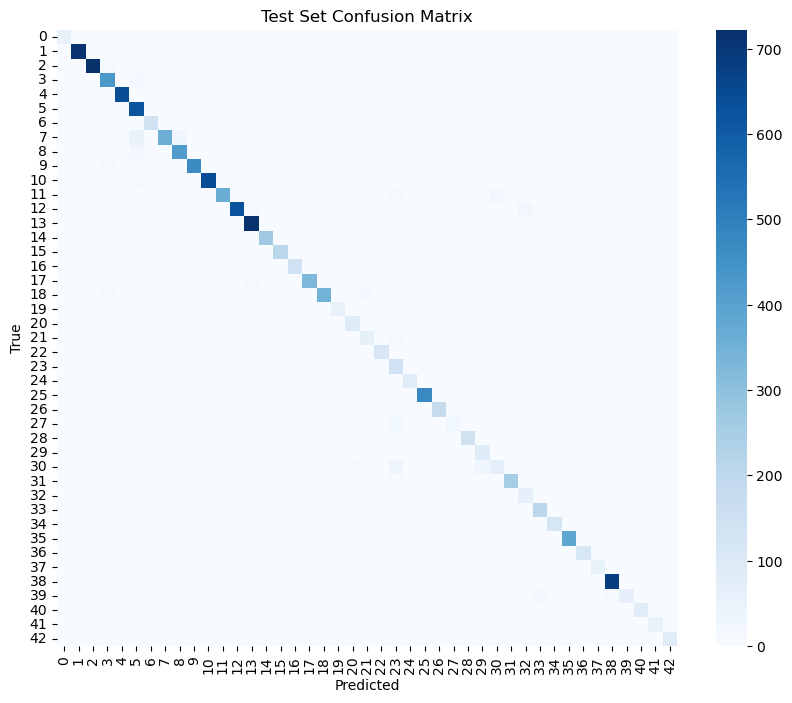

In [43]:
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Visualizing Model Predictions on Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


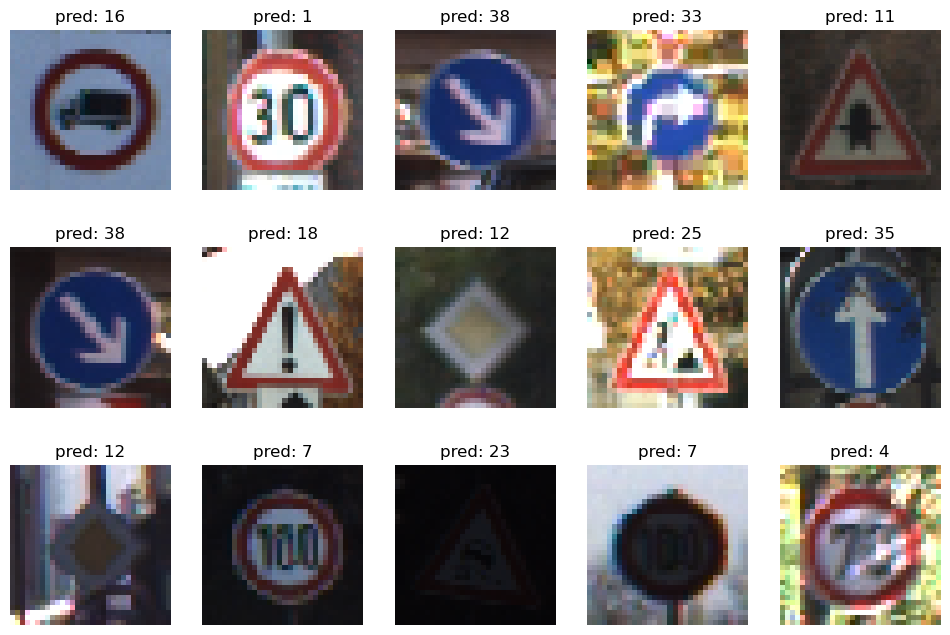

In [60]:
def predict_sample_images():
    fig, axes=plt.subplots (3,5, figsize=(12,8))
    for i, ax in enumerate (axes.flat):
        img=X_test[i]
        true_label= np.argmax(y_test[i])
        pred_label= np.argmax(model.predict(img.reshape(1,32,32,3)))
        ax.imshow(img)
        ax.set_title(f"pred: {pred_label}")
        ax.axis('off')
    plt.show()

predict_sample_images()

### Discussion

The experimental data prove that the CNN pipeline always provides very high validation scores for the different configurations tested, with most having accuracies of more than 0.98. The baseline models used BatchNormalization, moderate dropout, and data augmentation, resulting in higher generalization then those models without these features; the ablation studies also highlighted the contribution of each component, including the significant impact that data augmentation played in accommodating variations, and the role of BatchNormalization in producing stability in training.

Higher capacity architectures coupled with optimised regularisation yielded marginal gains indicating that there must be a balance between capacity and regularisation to produce the most robust learning of features from the GTSRB dataset. Overall the results support the idea that CNNs are a good choice for traffic sign recognition because all the options selected during model design will directly affect convergence rates and levels of generalisation.

### Limitations

The model was trained and tested using only the GTSRB Dataset and will therefore not generalise well to Non-German signs or significantly different environmental conditions. The cropped and centred images presented in the GTSRB dataset will not allow the model to contend with some of the more challenging aspects of real-world traffic sign recognition, particularly those resulting from direct environmental factors such as heavy occlusion, severe weather conditions, or uncropped scenes.

Similarly, because all experiments were conducted using individual static images, without the benefit of temporal context from video, it remains unknown how this approach would perform when using these same models on embedded platforms that would require real-time processing of the images. This introduces unknown factors into the performance characteristics of the model.

### Recommendations

To enhance the real-world utility of the model, it should be used in conjunction with an object detection algorithm for use with uncropped scenes. Additionally, it would be advantageous to utilise multiple country datasets for broader generalisation. Finally, video-based models can provide insight into the value of making use of temporal context.

#### Project Summary

1.Convolutional Neural Networks (CNNs) were able to achieve very high levels of accuracy in identifying traffic signs, with a minimum validation score above 0.98 and an almost perfect test accuracy near 0.99 on the GTSRB dataset, supporting the assertion that they are excellent at learning multi-layered visual characteristics through feature learning.

2.The use of Batch Normalization resulted in improved training stability and final performance; removal of this layer saw a drop in the number and smoothness of the accuracy curves throughout the course of training, indicating that it was a significant factor in the final classification accuracy.

3.Regularization using Moderate Dropout Rate (0.5) provided the best means to prevent overfitting and retain model capacity compared to higher rates of dropout which had a negative effect on the model.

4.Using Data Augmentation Techniques allowed for the model to be trained against real-world variances, but was not necessary to achieve the highest validation accuracy in the GTSRB dataset because the data itself contained many examples of vehicles and traffic signals that provided a large variety of training samples.

5.Increasing Model Depth showed diminishing returns when creating a model. For example, after adding more than three Convolutional block layers, there was little to no gain in accuracy for an increase in computation.

6.Using Smaller Filters allowed for the creation of smaller and lighter models for deployment, while offering similar levels of accuracy to compared to larger architectures.